<a href="https://www.kaggle.com/code/faiqueali/time-series-forecasting-karachi-temp-gm?scriptVersionId=184414961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
!pip install tqdm -q

In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

# Constant

In [3]:
DATASET_PATH = "/kaggle/input/weather-underground/weather_data.csv"

# Utils

In [4]:
# GM(1,1) model implementation
def gm11(x0):
    n = len(x0)
    x1 = np.cumsum(x0)  # Accumulated series
    z1 = (x1[:-1] + x1[1:]) / 2.0  # Mean sequence
    B = np.vstack([-z1, np.ones(n-1)]).T
    Y = x0[1:]
    u = np.linalg.lstsq(B, Y, rcond=None)[0]
    a, b = u
    f = lambda k: (x0[0] - b/a) * np.exp(-a * k) + b/a
    x0_hat = np.array([f(k) for k in range(n)])
    return x0_hat, a, b


# GM(1,N) model implementation
def gm1n(x0, N):
    n = len(x0)
    x1 = np.cumsum(x0)  # Accumulated series
    z1 = np.zeros(n-N)
    for i in range(n-N):
        z1[i] = (x1[i+N] - x1[i]) / N  # Mean sequence
    B = np.vstack([-z1, np.ones(n-N)]).T
    Y = x0[N:]
    u = np.linalg.lstsq(B, Y, rcond=None)[0]
    a, b = u
    f = lambda k: (x0[0] - b/a) * np.exp(-a * k) + b/a
    x0_hat = np.array([f(k) for k in range(n)])
    return x0_hat, a, b


# Forecast function
def forecast_gm11(model, history, steps):
    x0_hat, a, b = model(history)
    f = lambda k: (history[0] - b/a) * np.exp(-a * k) + b/a
    future_forecast = np.array([f(k + len(history)) for k in range(steps)])
    return future_forecast


def forecast_gm1n(model, history, steps, N):
    x0_hat, a, b = model(history, N)
    f = lambda k: (history[0] - b/a) * np.exp(-a * k) + b/a
    future_forecast = np.array([f(k + len(history)) for k in range(steps)])
    return future_forecast


# Perform iterative forecasting
def iterative_forecast_gm11(train, test, step_size):
    history = list(train)
    predictions = []
    for i in tqdm_notebook(range(0, len(test), step_size)):
        step_forecast = forecast_gm11(gm11, history, step_size)
        predictions.extend(step_forecast[:min(step_size, len(test) - i)])
        history.extend(test[i:i + step_size])
    return np.array(predictions)


# Perform iterative forecasting for GM(1,N)
def iterative_forecast_gm1n(train, test, step_size, N):
    history = list(train)
    predictions = []
    for i in tqdm_notebook(range(0, len(test), step_size)):
        step_forecast = forecast_gm1n(gm1n, history, step_size, N)
        predictions.extend(step_forecast[:min(step_size, len(test) - i)])
        history.extend(test[i:i + step_size])
    return np.array(predictions)

# Code

In [5]:
df = pd.read_csv(DATASET_PATH)

# Convert 'date' and 'time' column data types
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%I:%M %p').dt.time

# Combine 'date' and 'time' columns into a single datetime column
df['datetime'] = df.apply(lambda row: datetime.combine(row['date'], row['time']), axis=1)

# Drop the original 'date' and 'time' columns as they are no longer needed
df = df.drop(columns=['date', 'time'])

# Filter data from Jan'24 till May'24
start_date = '2024-01-01'
df = df[(df['datetime'] >= start_date)]

df.head(3)

,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition,city,country,datetime
1418,61,37,42,ENE,5,0,29.98,0.0,Haze,Karachi,Pakistan,2024-01-01 00:00:00
1419,61,37,42,N,5,0,29.95,0.0,Haze,Karachi,Pakistan,2024-01-01 00:30:00
1420,61,37,42,NNE,5,0,29.95,0.0,Haze,Karachi,Pakistan,2024-01-01 01:00:00


## Apply Differencing & Remove Outliers

In [6]:
df['temperature_diff'] = df['temperature'].diff().dropna()

## Splitting the dataset & fit GM(1,1)

In [7]:
df_train = df[(df['datetime'] < "2024-05-25")]
df_test = df[(df['datetime'] > "2024-05-25")]

# Prepare the differenced temperature data
temperature_diff_train = df_train['temperature_diff'].dropna()
temperature_diff_test = df_test['temperature_diff'].dropna()

print(f'Train data size: {temperature_diff_train.shape}')
print(f'Test data size: {temperature_diff_test.shape}')

Train data size: (6901,)
Test data size: (335,)


In [59]:
# Perform the forecasting
step_size = 3
predictions = iterative_forecast_gm11(temperature_diff_train, temperature_diff_test, step_size)

  0%|          | 0/112 [00:00<?, ?it/s]

In [60]:
results_df = pd.DataFrame({
    'datetime': df_test['datetime'].values[:len(predictions)],
    'actual': temperature_diff_test[:len(predictions)],
    'predicted': predictions
})

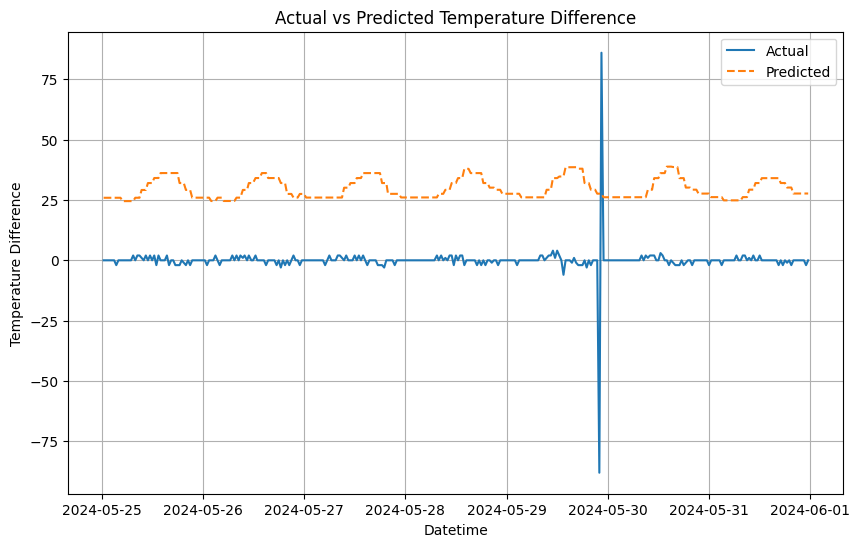

In [61]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))

plt.plot(results_df['datetime'], results_df['actual'].values, label='Actual')
plt.plot(results_df['datetime'], results_df['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.title('Actual vs Predicted Temperature Difference')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Assuming temperature_diff_test.index and forecasts are defined
index_values = results_df.index
forecast_values = results_df.predicted.values

# Create a DataFrame from the index and list values
df_forecast = pd.DataFrame({'Index': index_values, 'Forecasts': forecast_values})
df_forecast.head()

# Save the DataFrame to a CSV file
df_forecast.to_csv('GM_Forecasts.csv', index=False)